In [8]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

def hamming_weight_modulo(x,n,m):
    #x is input with decimal format
    # n is number of bit for hamming weight modulo function
    # m is modulo
    assert x<2**n
    bit = np.unpackbits(np.asarray(x,dtype=np.uint8),count=n,bitorder='l')
    return sum(bit)%m

def create_projector(partition,ntotal):
    ## for 5 qubit partition is [2,5,10,10,5]
    ## for 7 qubit partition is [2,7,21,35,35,21,7]
    ## ntotal is total number of qubit in VarQQA
    index_list = np.zeros(len(partition)+1,dtype=np.int64)
    index_list[1:]=np.cumsum(partition)
    projector_list = []
    for i in range(len(partition)):
        projector = np.zeros((2**ntotal,2**ntotal),dtype=np.complex128)
        for j in range(index_list[i],index_list[i+1]):
            projector[j][j] =1
        projector_list.append(projector)
    return projector_list
        

def oracle(x,num_bitstring,nquery,ntotal):
    # x is the demical form of the bitstring
    # num_bitstring is the len of input binary string
    # nquery is number of query register which is 3 for both 5bit and 7bit problem
    # ntotal is total number of qubit in VarQQA
    assert x <= 2**num_bitstring
    assert num_bitstring <=2**nquery
    I = np.eye(2**(ntotal-nquery),dtype=np.complex128)
    bit = np.unpackbits(np.asarray(x,dtype=np.uint8),count=num_bitstring,bitorder='l')
    Ox = np.eye(2**nquery,dtype=np.complex128)
    for i in range(num_bitstring):
        Ox[i][i] = (-1)**(bit[i])
    return np.kron(Ox,I)

def apply_circuit(state,unitary_list,x,ntotal,num_bitstring=5,nquery=3):
    for i in range(len(unitary_list)-1):
        state = unitary_list[i]@state
        Ox = oracle(x,num_bitstring,nquery,ntotal)
        state = Ox@state
    state = unitary_list[-1]@state
    return state


def hamming(x):
    #return hamming weight of x
    #x is decimal form input
    return np.sum(np.unpackbits(np.array(x,dtype=np.uint8)))

def hamming_map(n,m):
    tmp = np.zeros(1<<n,dtype=np.int64)
    for i in range(1<<n):
        tmp[i] = hamming(i)%m
    return tmp

def sort_hamming(n,m):
    ham= hamming_map(n,m)
    string_list =[i for i in range(1<<n)]
    string_list.sort(key= lambda x:ham[x])
    return string_list

## For 5bit mod 5 hamming weight modulo problem

In [2]:
with open("unitary_data/5-qubit_4-query.pickle","rb") as f:
    data = pickle.load(f)

num_qubit = data["num_qubit"]
num_query_bit = 3
num_bitstring = data["num_bitstring"]
num_modulo = data["num_modulo"]
unitary_list = data["unitary_list"]
partition = data["partition"]
projector_list = create_projector(partition,num_qubit)

In [3]:
total_success_rate =0
for x in range(2**num_bitstring):
    state = np.zeros(2**num_qubit,dtype=np.complex128)
    state[0]=1
    q0=apply_circuit(state,unitary_list,x,num_qubit,num_bitstring=num_bitstring)
    success_rate  = np.dot(q0.conj(),projector_list[hamming_weight_modulo(x,num_bitstring,num_modulo)]@q0)
    total_success_rate += success_rate.real
    print(x,success_rate)
print("average success rate :%1.9f"%(total_success_rate/2**num_bitstring))

0 (0.9999999976383329+0j)
1 (0.9999999980987258+0j)
2 (0.9999999983741799+0j)
3 (0.9999999987510707+0j)
4 (0.9999999975263496+0j)
5 (0.9999999988152489+0j)
6 (0.9999999982926768+0j)
7 (0.9999999990114901+0j)
8 (0.9999999979009835+0j)
9 (0.9999999985872494+0j)
10 (0.9999999988794581+0j)
11 (0.9999999990433703+0j)
12 (0.9999999984120053+0j)
13 (0.9999999989622788+0j)
14 (0.999999998360469+0j)
15 (0.9999999980849283+0j)
16 (0.9999999976421743+0j)
17 (0.9999999983331647+0j)
18 (0.9999999986199014+0j)
19 (0.9999999988165199+0j)
20 (0.9999999981030048+0j)
21 (0.9999999989725531+0j)
22 (0.9999999987464979+0j)
23 (0.9999999985056973+0j)
24 (0.9999999986767656+0j)
25 (0.9999999986305306+0j)
26 (0.9999999986056951+0j)
27 (0.9999999981852337+0j)
28 (0.9999999989975552+0j)
29 (0.9999999985452226+0j)
30 (0.9999999976213002+0j)
31 (0.999999997461892+0j)
average success rate :0.999999998


## To get the gram matrix

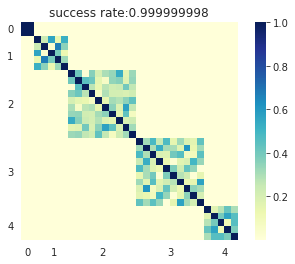

In [4]:
string_list = sort_hamming(5,5)

state_matrix = np.zeros((2**num_qubit,2**num_qubit),dtype=np.complex128)
for x in range(2**num_bitstring):
    state = np.zeros(2**num_qubit,dtype=np.complex128)
    state[0]=1
    state_matrix[x,:]=apply_circuit(state,unitary_list,x,num_qubit,num_bitstring=num_bitstring)

gram = np.zeros((1<<num_bitstring,1<<num_bitstring),dtype=np.complex128)

for i in range(2**num_bitstring):
    for j in range(2**num_bitstring):
        gram[i][j] = np.dot(state_matrix[string_list[i]].conj(),state_matrix[string_list[j]])


with sns.axes_style("white"):
    sns.heatmap(np.abs(gram),square=True,cmap="YlGnBu")
    plt.yticks([1,5,12,22,30],["0","1","2","3","4"],rotation = 0)
    plt.xticks([1,5,12,22,30],["0","1","2","3","4"],rotation = 0)
    plt.title("success rate:%1.9f"%(total_success_rate/2**num_bitstring))

## For 7 bit mod 7 case

In [5]:
with open("unitary_data/7-qubit_6-query.pickle","rb") as f:
    data = pickle.load(f)

num_qubit = data["num_qubit"]
num_query_bit = 3
num_bitstring = data["num_bitstring"]
num_modulo = data["num_modulo"]
unitary_list = data["unitary_list"]
partition = data["partition"]
projector_list = create_projector(partition,num_qubit)

In [6]:
total_success_rate =0
for x in range(2**num_bitstring):
    state = np.zeros(2**num_qubit,dtype=np.complex128)
    state[0]=1
    q0=apply_circuit(state,unitary_list,x,num_qubit,num_bitstring=num_bitstring)
    success_rate  = np.dot(q0.conj(),projector_list[hamming_weight_modulo(x,num_bitstring,num_modulo)]@q0)
    total_success_rate += success_rate.real
    print(x,success_rate)
print("average success rate :%1.9f"%(total_success_rate/2**num_bitstring))

0 (0.9999980682351964+0j)
1 (0.9999962911324924+0j)
2 (0.9999963093889817+0j)
3 (0.9999959983149059+0j)
4 (0.9999964003108353+0j)
5 (0.9999959458511383+0j)
6 (0.9999961087787769+0j)
7 (0.9999959901529906+0j)
8 (0.9999967078551669+0j)
9 (0.9999958833048853+0j)
10 (0.9999959761259987+0j)
11 (0.9999960748778713+0j)
12 (0.9999961349192295+0j)
13 (0.9999960353506145+0j)
14 (0.9999961401948474+0j)
15 (0.9999961534610223+0j)
16 (0.9999964008518052+0j)
17 (0.9999962791763068+0j)
18 (0.9999962415506161+0j)
19 (0.9999964182587344+0j)
20 (0.9999961819564438+0j)
21 (0.9999961270922986+0j)
22 (0.9999963432575418+0j)
23 (0.9999962887702467+0j)
24 (0.9999962397632067+0j)
25 (0.9999960941285279+0j)
26 (0.9999962471208859+0j)
27 (0.9999961481667519+0j)
28 (0.9999961899480325+0j)
29 (0.99999626550911+0j)
30 (0.9999962138249516+0j)
31 (0.999996466627646+0j)
32 (0.9999964594051204+0j)
33 (0.9999960626716812+0j)
34 (0.9999962924954078+0j)
35 (0.9999960929269219+0j)
36 (0.9999959142277904+0j)
37 (0.99999618

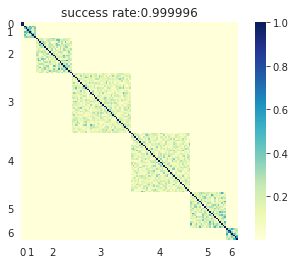

In [7]:
string_list = sort_hamming(7,7)

state_matrix = np.zeros((2**num_qubit,2**num_qubit),dtype=np.complex128)
for x in range(2**num_bitstring):
    state = np.zeros(2**num_qubit,dtype=np.complex128)
    state[0]=1
    state_matrix[x,:]=apply_circuit(state,unitary_list,x,num_qubit,num_bitstring=num_bitstring)

gram = np.zeros((1<<num_bitstring,1<<num_bitstring),dtype=np.complex128)

for i in range(2**num_bitstring):
    for j in range(2**num_bitstring):
        gram[i][j] = np.dot(state_matrix[string_list[i]].conj(),state_matrix[string_list[j]])

with sns.axes_style("white"):
    sns.heatmap(np.abs(gram),square=True,cmap="YlGnBu")
    plt.yticks([1,6,19,47,82,110,124],["0","1","2","3","4","5","6"],rotation = 0)
    plt.xticks([1,6,19,47,82,110,124],["0","1","2","3","4","5","6"],rotation = 0)
    plt.title("success rate:%1.6f"%(total_success_rate/2**num_bitstring))